In [1]:
#I want to make sure I get all the libraries in here that I will need.
import numpy as np 
import pandas as pd 

import requests 

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import types

from sklearn.cluster import KMeans

print('All Systems Go...')

All Systems Go...


## Get Folium and Nominatim here

In [2]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

!conda install -c conda-forge folium=0.5.0 --yes
import folium

^C
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\jgles\miniconda3\envs\myenv

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.12.5  |       h5b45459_0         173 KB  conda-forge
    certifi-2020.12.5          |   py37h03978a9_1         143 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    openssl-1.1.1k             |       h8ffe710_0         5.7 MB  conda-forge
    python_abi-3.7             |          1_cp37m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         6.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geog

In [68]:
vbhoods = pd.read_csv("../input/hrdfdata/HRDF.csv")
vbhoods.head()


,Lat,Long,City,Neighborhood,Zillow Home Value,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized,Median Value/SQFT,Monthly +/- in MVSF,Quarterly +/- in MVSF,Yearly +/- in MVSF,Zillow Rent Index,Monthly +/- Rent,Quarterly +/- Rent,Yearly +/- Rent
0,36.910581,-76.056263,Virginia Beach City,Cape Story by the Sea,635900,0.007,0.017,0.043,0.02,0.004,271,0.004,0.015,0.042,---,---,---,---
1,36.878245,-76.026138,Virginia Beach City,Alanton,480900,0.007,0.020,0.048,0.024,0.011,1506,0.007,0.020,0.047,2193,-0.009,-0.021,0.047
2,36.865052,-76.124002,Virginia Beach City,Pembroke,316000,0.005,0.017,0.032,0.021,0.005,145,0.000,0.014,0.028,1826,0.009,0.011,0.03
3,36.863567,-76.087527,Virginia Beach City,Kings Grant,383100,0.004,0.013,0.031,0.016,0.009,849,0.004,0.013,0.032,1957,-0.004,-0.034,0.007
4,36.793428,-76.005317,Virginia Beach City,Macons Corner,236100,0.005,0.016,0.042,0.019,0.005,188,0.005,0.016,0.039,---,---,---,---


In [69]:
address = '310 Edwin Dr, Virginia Beach, VA 23462'

geolocator = Nominatim(user_agent="vb_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Virginia Beach, VA are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Virginia Beach, VA are 36.824994557635605, -76.13185019948901.


In [70]:
# create map of Va Beach using latitude and longitude values
map_vb = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(vbhoods['Lat'], vbhoods['Long'], vbhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='#78609e',
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vb)  
    
map_vb

In [71]:
CLIENT_ID = 'TVJWUE15PRCVHC0JWOGO0DQMGUJT11D0REZ04AJK1G2JZ3HY' # your Foursquare ID
CLIENT_SECRET = 'DQ2E1HBT4GPJVRIAURN04Q5VVAAVVDWSJNHYDPP4TJG5OKGI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TVJWUE15PRCVHC0JWOGO0DQMGUJT11D0REZ04AJK1G2JZ3HY
CLIENT_SECRET:DQ2E1HBT4GPJVRIAURN04Q5VVAAVVDWSJNHYDPP4TJG5OKGI


In [72]:
vbhoods.loc[1, 'Neighborhood']

'Alanton'

In [73]:
neighborhood_latitude = vbhoods.loc[2, 'Lat'] # neighborhood latitude value
neighborhood_longitude = vbhoods.loc[2, 'Long'] # neighborhood longitude value

neighborhood_name = vbhoods.loc[2, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Pembroke are 36.8650521869, -76.1240022262.


In [74]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url  

'https://api.foursquare.com/v2/venues/explore?&client_id=TVJWUE15PRCVHC0JWOGO0DQMGUJT11D0REZ04AJK1G2JZ3HY&client_secret=DQ2E1HBT4GPJVRIAURN04Q5VVAAVVDWSJNHYDPP4TJG5OKGI&v=20180605&ll=36.8650521869,-76.1240022262&radius=1000&limit=100'

In [75]:
#Here is where we will go ahead and make the pulls of data.  Lets make sure we are good here

In [76]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ec6b68db9a389001bb19a33'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Pembroke Meadows',
  'headerFullLocation': 'Pembroke Meadows, Virginia Beach',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 17,
  'suggestedBounds': {'ne': {'lat': 36.87405219590001,
    'lng': -76.11277393214412},
   'sw': {'lat': 36.85605217789999, 'lng': -76.13523052025589}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b45560bf964a520d60a26e3',
       'name': 'Cinema Cafe',
       'location': {'address': '758 Independence Blvd',
        'crossStreet': 'at Pembroke Blvd',
        'lat': 36.86471515009411,
        'lng': -76.13116795676811,
    

In [77]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [78]:
from pandas.io.json import json_normalize
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,name,categories,lat,lng
0,Cinema Cafe,Movie Theater,36.864715,-76.131168
1,Five Guys,Burger Joint,36.864139,-76.130976
2,Walgreens,Pharmacy,36.866056,-76.133014
3,Red Lobster,Seafood Restaurant,36.863187,-76.132716
4,7-Eleven,Convenience Store,36.863020,-76.131575


In [79]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

17 venues were returned by Foursquare.


In [80]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [81]:
vb_venues = getNearbyVenues(names=vbhoods['Neighborhood'],
                                   latitudes=vbhoods['Lat'],
                                   longitudes=vbhoods['Long']
                                  )


Cape Story by the Sea
Alanton
Pembroke
Kings Grant
Macons Corner
Lynnhaven Shores
Acredale
Bay Colony
Sandbridge
First Landing State Park
Linkhorn Park
US Navy Little Creek Amphibious Base
Broad Bay Colony
Rudee Heights
Kempsville
Bayside
Seatack
Croatan Beach
Mears Corner
Princess Anne Plaza
Thalia
Oceana
The North End
Princess Anne
Dams Neck Naval Air Station
Thoroughgood
Naval Air Station Oceana
Chesapeake Beach
Chesapeake Beach
Great Neck
Green Run
Salem
Indian River
Great Bridge
Western Branch North
Butts Station
South Norfolk
South Norfolk
Deep Creek North
Great Bridge East
Western Branch South
Pleasant Grove West
Greenbrier West
Deep Creek South
Greenbrier East
Deep Creek West-Dismal Swamp
Pleasant Grove East
The Gardens
Edgewater
Camellia Gardens
Estabrook
Lochhaven
Bowling Green
West Ghent
Wards Corner
Wellington Oaks
Norview
Talbot Park
Glengariff
Lamberts Point
Greenhill Farms
Waverly on Broad Creek
Bolling Brook
River Point
Bel-Aire
Sherwood Forest
Highland Park
Poplar Hall

In [82]:
vb_venues.shape

(3394, 7)

In [83]:
venue_hist=vb_venues.groupby('Neighborhood').count()
venue_hist.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1, inplace=True)
venue_hist.head()

,Venue
Neighborhood,
Acredale,8
Alanton,7
Algonquin,5
Ballentine Place,17
Bay Colony,6


Text(0.5, 0, '# of Venues')

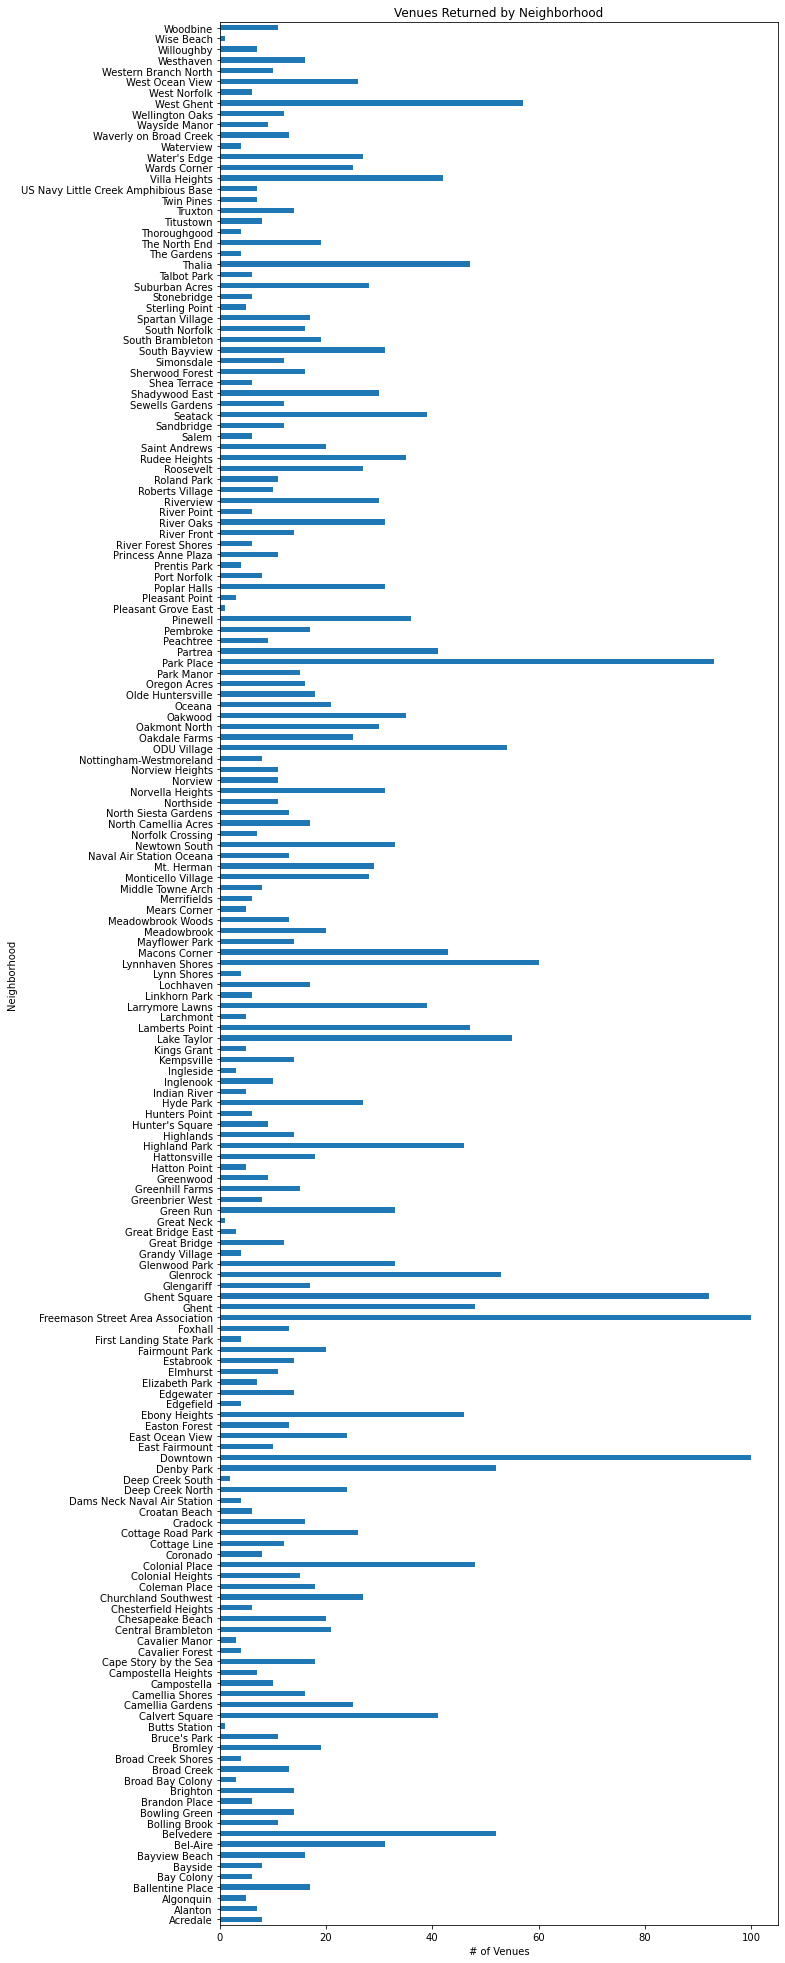

In [84]:
venue_hist['Venue'].plot(kind='barh', figsize=(10,35))

plt.title('Venues Returned by Neighborhood') # add a title to the histogram
plt.ylabel('Neighborhood') # add y-label
plt.xlabel('# of Venues') # add x-label
#plt.savefig('venues-neighborhoods.png')

In [85]:
print('There are {} uniques categories.'.format(len(vb_venues['Venue Category'].unique())))

There are 274 uniques categories.


In [86]:
# one hot encoding
vb_onehot = pd.get_dummies(vb_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
vb_onehot['Neighborhood'] = vb_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [vb_onehot.columns[-1]] + list(vb_onehot.columns[:-1])
vb_onehot = vb_onehot[fixed_columns]

vb_onehot.head()

,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Vietnamese Restaurant,Warehouse Store,Waterfront,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
vb_onehot.shape

(3394, 274)

In [88]:
vb_grouped = vb_onehot.groupby('Neighborhood').mean().reset_index()
vb_grouped

,Neighborhood,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vietnamese Restaurant,Warehouse Store,Waterfront,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Acredale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alanton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Algonquin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ballentine Place,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bay Colony,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,Western Branch North,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173,Westhaven,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174,Willoughby,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
175,Wise Beach,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
num_top_venues = 5

for hood in vb_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = vb_grouped[vb_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Acredale----
                        venue  freq
0  Construction & Landscaping  0.25
1                         Gym  0.12
2                        Park  0.12
3                        Pool  0.12
4           Food & Drink Shop  0.12


----Alanton----
           venue  freq
0   Cupcake Shop  0.14
1           Pool  0.14
2  Boat or Ferry  0.14
3     Sports Bar  0.14
4   Hockey Field  0.14


----Algonquin----
                venue  freq
0  Chinese Restaurant   0.4
1       Garden Center   0.2
2         Pizza Place   0.2
3                Park   0.2
4         Zoo Exhibit   0.0


----Ballentine Place----
                  venue  freq
0     Convenience Store  0.18
1        Breakfast Spot  0.06
2      Community Center  0.06
3  Gym / Fitness Center  0.06
4                  Park  0.06


----Bay Colony----
             venue  freq
0       Shoe Store  0.17
1           Cruise  0.17
2  Harbor / Marina  0.17
3             Food  0.17
4           Garden  0.17


----Bayside----
              venue  freq
0

                 venue  freq
0  Rental Car Location  0.27
1       Sandwich Place  0.09
2       Breakfast Spot  0.09
3                 Food  0.09
4            Bookstore  0.09


----Estabrook----
               venue  freq
0  Convenience Store  0.14
1  French Restaurant  0.07
2       Burger Joint  0.07
3  Martial Arts Dojo  0.07
4         Shoe Store  0.07


----Fairmount Park----
                 venue  freq
0  Fried Chicken Joint  0.10
1       Discount Store  0.10
2    Convenience Store  0.10
3             Pharmacy  0.10
4             Bus Stop  0.05


----First Landing State Park----
                     venue  freq
0                    Trail  0.75
1                    Beach  0.25
2              Zoo Exhibit  0.00
3  New American Restaurant  0.00
4              Opera House  0.00


----Foxhall----
                venue  freq
0   Convenience Store  0.23
1     Automotive Shop  0.15
2      Shipping Store  0.08
3  Seafood Restaurant  0.08
4   Electronics Store  0.08


----Freemason Street Are

                venue  freq
0  Chinese Restaurant  0.33
1   Convenience Store  0.17
2      Clothing Store  0.17
3                Park  0.17
4        Soccer Field  0.17


----Middle Towne Arch----
               venue  freq
0        Gas Station  0.12
1  Convenience Store  0.12
2        Pizza Place  0.12
3       Home Service  0.12
4          Juice Bar  0.12


----Monticello Village----
                  venue  freq
0        Discount Store  0.07
1           Supermarket  0.07
2    Mexican Restaurant  0.07
3  Fast Food Restaurant  0.07
4           Coffee Shop  0.07


----Mt. Herman----
                  venue  freq
0  Fast Food Restaurant  0.14
1     Convenience Store  0.10
2           Video Store  0.07
3           Pizza Place  0.07
4    Italian Restaurant  0.07


----Naval Air Station Oceana----
              venue  freq
0  Basketball Court  0.23
1     Movie Theater  0.15
2  Airport Terminal  0.15
3               Gym  0.08
4             Hotel  0.08


----Newtown South----
                 

                venue  freq
0   Convenience Store  0.14
1          Donut Shop  0.07
2            Pharmacy  0.07
3      Baseball Field  0.07
4  Chinese Restaurant  0.07


----Twin Pines----
                    venue  freq
0      Chinese Restaurant  0.29
1    Fast Food Restaurant  0.14
2  Thrift / Vintage Store  0.14
3             Pizza Place  0.14
4         Organic Grocery  0.14


----US Navy Little Creek Amphibious Base----
            venue  freq
0     Golf Course  0.29
1   Boat or Ferry  0.14
2          Lounge  0.14
3  Baseball Field  0.14
4           Beach  0.14


----Villa Heights----
                  venue  freq
0               Exhibit  0.14
1        Discount Store  0.07
2               Brewery  0.07
3  Gym / Fitness Center  0.05
4     Convenience Store  0.05


----Wards Corner----
                venue  freq
0  Mexican Restaurant  0.12
1      Sandwich Place  0.08
2         Pizza Place  0.08
3            Pharmacy  0.08
4   Convenience Store  0.08


----Water's Edge----
          

In [131]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [132]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = vb_grouped['Neighborhood']

for ind in np.arange(vb_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(vb_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Acredale,Construction & Landscaping,Food & Drink Shop,Gym,Park,Food
1,Alanton,Pool,Cupcake Shop,Boat or Ferry,Fishing Spot,Soccer Field
2,Algonquin,Chinese Restaurant,Park,Pizza Place,Garden Center,Zoo
3,Ballentine Place,Convenience Store,American Restaurant,Electronics Store,Fried Chicken Joint,Grocery Store
4,Bay Colony,Food,Shoe Store,Harbor / Marina,Garden,American Restaurant


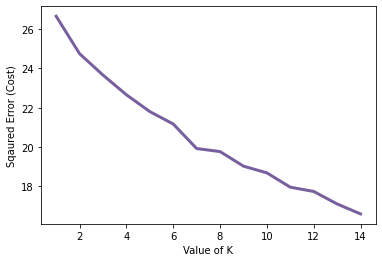

In [92]:
# Setting up Elbow Analysis
cost =[] 
for i in range(1, 15): 
	KM = KMeans(n_clusters = i, max_iter = 500) 
	KM.fit(vb_grouped_clustering) 
	
	# calculates squared error 
	# for the clustered points 
	cost.append(KM.inertia_)	 

# plot the cost against K values 
plt.plot(range(1, 15), cost, color ='#78609e', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

# the point of the elbow is the 
# most optimal value for choosing k 

In [133]:
# set number of clusters
kclusters = 7

vb_grouped_clustering = vb_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vb_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([4, 4, 6, 6, 4, 4, 6, 4, 4, 4, 6, 6, 6, 0, 2, 4, 6, 0, 4, 4, 4, 4,
       4, 2, 0, 4, 6, 2, 0, 2, 4, 6, 4, 4, 0, 6, 4, 6, 0, 3, 6, 4, 4, 4,
       6, 0, 4, 4, 4, 4, 4, 4, 6, 6, 4, 6, 4, 4, 4, 4, 4, 4, 2, 4, 4, 1,
       4, 0, 0, 6, 4, 4, 4, 4, 0, 4, 6, 4, 0, 2, 4, 4, 4, 4, 4, 4, 6, 4,
       4, 4, 4, 4, 4, 6, 4, 6, 2, 4, 6, 4, 4, 4, 4, 4, 6, 6, 6, 6, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 6, 5, 4, 4, 6, 6, 6, 4, 6, 4, 4,
       4, 0, 0, 4, 0, 6, 4, 3, 4, 6, 6, 6, 6, 4, 4, 2, 6, 2, 4, 2, 4, 4,
       4, 6, 3, 4, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 6, 4, 0, 4, 4, 6, 0, 1,
       4], dtype=int32)

In [137]:
#Hide this code when running a new pass
#vb_merged.drop(['Cluster Labels'], axis=1, inplace=True)
#vb_merged.head()

In [139]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

vb_merged = vbhoods

# merge to add latitude/longitude for each neighborhood
vb_merged = vb_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

vb_merged.head(50) # check the last rows!
vb_merged.sort_values(by="Cluster Labels")

,Lat,Long,City,Neighborhood,Zillow Home Value,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized,...,Zillow Rent Index,Monthly +/- Rent,Quarterly +/- Rent,Yearly +/- Rent,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,36.910581,-76.056263,Virginia Beach City,Cape Story by the Sea,635900,0.007,0.017,0.043,0.02,0.004,...,---,---,---,---,0.0,Construction & Landscaping,Trail,Harbor / Marina,Video Store,Drugstore
156,36.856640,-76.267844,Norfolk City,Bruce's Park,152900,-0.007,-0.018,0.028,0.033,-0.004,...,NaN,NaN,NaN,NaN,0.0,Seafood Restaurant,Fried Chicken Joint,Pool,Fast Food Restaurant,Performing Arts Venue
153,36.927663,-76.195268,Norfolk City,East Ocean View,353400,-0.003,-0.003,0.023,0.024,0.001,...,NaN,NaN,NaN,NaN,0.0,Seafood Restaurant,Harbor / Marina,Convenience Store,Home Service,Recreation Center
140,36.965160,-76.280284,Norfolk City,Willoughby,224400,0.000,0.000,0.026,0.023,-0.012,...,NaN,NaN,NaN,NaN,0.0,Beach,Convenience Store,Harbor / Marina,Food,Motel
123,36.901269,-76.254011,Norfolk City,Inglenook,163700,0.013,0.023,0.055,0.025,0.002,...,NaN,NaN,NaN,NaN,0.0,Home Service,Construction & Landscaping,Video Store,Dessert Shop,Seafood Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,36.653547,-76.005716,Virginia Beach City,Princess Anne,350200,0.003,0.011,0.028,0.023,0.012,...,1895,0.002,-0.016,0.02,NaN,NaN,NaN,NaN,NaN,NaN
40,36.797316,-76.425862,Chesapeake City,Western Branch South,305700,0.005,0.013,0.039,0.025,0.008,...,1713,-0.006,-0.009,0.011,NaN,NaN,NaN,NaN,NaN,NaN
41,36.617803,-76.296487,Chesapeake City,Pleasant Grove West,427400,0.004,0.010,0.019,0.026,0.009,...,2180,-0.011,-0.027,-0.003,NaN,NaN,NaN,NaN,NaN,NaN
44,36.748931,-76.186476,Chesapeake City,Greenbrier East,297100,0.004,0.011,0.026,0.02,0.005,...,1733,-0.013,-0.014,0.005,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
print(vb_merged['Cluster Labels'].value_counts())

4.0    104
6.0     46
0.0     18
2.0     10
3.0      3
1.0      2
5.0      1
Name: Cluster Labels, dtype: int64


In [141]:
vb_null = vb_merged[vb_merged['Cluster Labels'].isnull()]
vb_null.shape

(5, 24)

In [142]:
vb_merged.sort_values(by="Cluster Labels")


,Lat,Long,City,Neighborhood,Zillow Home Value,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized,...,Zillow Rent Index,Monthly +/- Rent,Quarterly +/- Rent,Yearly +/- Rent,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,36.910581,-76.056263,Virginia Beach City,Cape Story by the Sea,635900,0.007,0.017,0.043,0.02,0.004,...,---,---,---,---,0.0,Construction & Landscaping,Trail,Harbor / Marina,Video Store,Drugstore
156,36.856640,-76.267844,Norfolk City,Bruce's Park,152900,-0.007,-0.018,0.028,0.033,-0.004,...,NaN,NaN,NaN,NaN,0.0,Seafood Restaurant,Fried Chicken Joint,Pool,Fast Food Restaurant,Performing Arts Venue
153,36.927663,-76.195268,Norfolk City,East Ocean View,353400,-0.003,-0.003,0.023,0.024,0.001,...,NaN,NaN,NaN,NaN,0.0,Seafood Restaurant,Harbor / Marina,Convenience Store,Home Service,Recreation Center
140,36.965160,-76.280284,Norfolk City,Willoughby,224400,0.000,0.000,0.026,0.023,-0.012,...,NaN,NaN,NaN,NaN,0.0,Beach,Convenience Store,Harbor / Marina,Food,Motel
123,36.901269,-76.254011,Norfolk City,Inglenook,163700,0.013,0.023,0.055,0.025,0.002,...,NaN,NaN,NaN,NaN,0.0,Home Service,Construction & Landscaping,Video Store,Dessert Shop,Seafood Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,36.653547,-76.005716,Virginia Beach City,Princess Anne,350200,0.003,0.011,0.028,0.023,0.012,...,1895,0.002,-0.016,0.02,NaN,NaN,NaN,NaN,NaN,NaN
40,36.797316,-76.425862,Chesapeake City,Western Branch South,305700,0.005,0.013,0.039,0.025,0.008,...,1713,-0.006,-0.009,0.011,NaN,NaN,NaN,NaN,NaN,NaN
41,36.617803,-76.296487,Chesapeake City,Pleasant Grove West,427400,0.004,0.010,0.019,0.026,0.009,...,2180,-0.011,-0.027,-0.003,NaN,NaN,NaN,NaN,NaN,NaN
44,36.748931,-76.186476,Chesapeake City,Greenbrier East,297100,0.004,0.011,0.026,0.02,0.005,...,1733,-0.013,-0.014,0.005,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
vb_merged.drop([23,40,41,44,45], inplace=True)
vb_merged.sort_values(by="Cluster Labels")

,Lat,Long,City,Neighborhood,Zillow Home Value,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized,...,Zillow Rent Index,Monthly +/- Rent,Quarterly +/- Rent,Yearly +/- Rent,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,36.910581,-76.056263,Virginia Beach City,Cape Story by the Sea,635900,0.007,0.017,0.043,0.02,0.004,...,---,---,---,---,0.0,Construction & Landscaping,Trail,Harbor / Marina,Video Store,Drugstore
156,36.856640,-76.267844,Norfolk City,Bruce's Park,152900,-0.007,-0.018,0.028,0.033,-0.004,...,NaN,NaN,NaN,NaN,0.0,Seafood Restaurant,Fried Chicken Joint,Pool,Fast Food Restaurant,Performing Arts Venue
153,36.927663,-76.195268,Norfolk City,East Ocean View,353400,-0.003,-0.003,0.023,0.024,0.001,...,NaN,NaN,NaN,NaN,0.0,Seafood Restaurant,Harbor / Marina,Convenience Store,Home Service,Recreation Center
140,36.965160,-76.280284,Norfolk City,Willoughby,224400,0.000,0.000,0.026,0.023,-0.012,...,NaN,NaN,NaN,NaN,0.0,Beach,Convenience Store,Harbor / Marina,Food,Motel
123,36.901269,-76.254011,Norfolk City,Inglenook,163700,0.013,0.023,0.055,0.025,0.002,...,NaN,NaN,NaN,NaN,0.0,Home Service,Construction & Landscaping,Video Store,Dessert Shop,Seafood Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,36.877528,-76.244420,Norfolk City,Estabrook,178200,0.005,0.007,0.037,0.03,-0.001,...,NaN,NaN,NaN,NaN,6.0,Convenience Store,Electronics Store,Fried Chicken Joint,IT Services,Pharmacy
47,36.908645,-76.204227,Norfolk City,The Gardens,439600,0.003,0.009,0.010,0.008,0.008,...,NaN,NaN,NaN,NaN,6.0,Convenience Store,Botanical Garden,Airport,Café,Farm
154,36.875511,-76.248955,Norfolk City,East Fairmount,135600,0.009,0.020,0.080,0.033,-0.004,...,NaN,NaN,NaN,NaN,6.0,Convenience Store,Pharmacy,Athletics & Sports,Burger Joint,Electronics Store
10,36.859199,-76.002964,Virginia Beach City,Linkhorn Park,473000,0.004,0.015,0.042,0.024,0.006,...,1891,-0.006,-0.014,0.04,6.0,Italian Restaurant,Convenience Store,Thai Restaurant,Bakery,Board Shop


In [154]:
vb_merged.to_csv('DataforTableauk7.csv')

In [144]:
# create map
#folium.TileLayer('MapQuest Open Aerial').add_to(map_clusters)
map_clusters = folium.Map(location=[latitude, longitude], tiles='stamenterrain', zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vb_merged['Lat'], vb_merged['Long'], vb_merged['Neighborhood'], vb_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=False,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

In [145]:
vb_merged.sort_values(by="Month Over Month", ascending=False)

,Lat,Long,City,Neighborhood,Zillow Home Value,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized,...,Zillow Rent Index,Monthly +/- Rent,Quarterly +/- Rent,Yearly +/- Rent,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
188,36.816715,-76.313086,Portsmouth City,Brighton,118000,0.028,0.072,0.220,0.034,0.009,...,---,---,---,---,6.0,Convenience Store,ATM,Café,Event Space,Bowling Alley
167,36.823499,-76.315447,Portsmouth City,Prentis Park,133000,0.024,0.065,0.237,0.066,0.013,...,1155,0,0.024,0.086,6.0,Convenience Store,Insurance Office,Discount Store,Deli / Bodega,Farmers Market
184,36.841641,-76.325696,Portsmouth City,Shea Terrace,168700,0.015,0.041,0.102,0.031,0.017,...,---,---,---,---,6.0,Convenience Store,Pier,Seafood Restaurant,Chinese Restaurant,Park
119,36.846597,-76.273982,Norfolk City,South Brambleton,94900,0.014,0.035,0.042,---,---,...,NaN,NaN,NaN,NaN,2.0,Light Rail Station,Food,Train Station,Plaza,Home Service
123,36.901269,-76.254011,Norfolk City,Inglenook,163700,0.013,0.023,0.055,0.025,0.002,...,NaN,NaN,NaN,NaN,0.0,Home Service,Construction & Landscaping,Video Store,Dessert Shop,Seafood Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,36.829022,-76.267743,Norfolk City,Campostella,132300,-0.008,-0.015,0.015,0.028,---,...,NaN,NaN,NaN,NaN,4.0,Fast Food Restaurant,Park,Convenience Store,Storage Facility,Liquor Store
148,36.862815,-76.274551,Norfolk City,Olde Huntersville,126000,-0.008,-0.016,0.084,0.021,-0.023,...,NaN,NaN,NaN,NaN,4.0,Fast Food Restaurant,Art Gallery,Fried Chicken Joint,Theater,Thrift / Vintage Store
161,36.817924,-76.337196,Portsmouth City,Truxton,111400,-0.009,-0.021,0.023,0.001,-0.009,...,---,---,---,---,6.0,Convenience Store,Grocery Store,Pizza Place,Pharmacy,Seafood Restaurant
99,36.897382,-76.220483,Norfolk City,Bromley,197800,-0.011,-0.021,0.060,0.043,0.022,...,NaN,NaN,NaN,NaN,6.0,Discount Store,Fast Food Restaurant,Convenience Store,Supermarket,Rental Car Location


In [155]:
#We will create dfs for each cluster so that we can study them in detail.
clus0=vb_merged.loc[vb_merged['Cluster Labels']== 0.0]
clus0.head()

,Lat,Long,City,Neighborhood,Zillow Home Value,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized,...,Zillow Rent Index,Monthly +/- Rent,Quarterly +/- Rent,Yearly +/- Rent,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,36.910581,-76.056263,Virginia Beach City,Cape Story by the Sea,635900,0.007,0.017,0.043,0.02,0.004,...,---,---,---,---,0.0,Construction & Landscaping,Trail,Harbor / Marina,Video Store,Drugstore
12,36.905367,-76.048580,Virginia Beach City,Broad Bay Colony,795900,0.002,0.010,0.024,0.033,-0.001,...,---,---,---,---,0.0,Health & Beauty Service,Boat or Ferry,Harbor / Marina,Farm,Ethiopian Restaurant
13,36.827265,-75.976421,Virginia Beach City,Rudee Heights,357900,0.004,0.011,0.019,0.021,0.004,...,---,---,---,---,0.0,Seafood Restaurant,Surf Spot,Beach,Hotel,Boat or Ferry
17,36.822425,-75.967325,Virginia Beach City,Croatan Beach,832100,0.003,0.011,0.023,0.014,0.005,...,---,---,---,---,0.0,Surf Spot,Playground,Boat or Ferry,Beach,Waterfront
27,36.914333,-76.119735,Virginia Beach City,Chesapeake Beach,419900,0.004,0.010,0.035,0.024,0.011,...,1990,-0.007,-0.017,0.051,0.0,Beach,Seafood Restaurant,Convenience Store,Italian Restaurant,Beach Bar


In [156]:
clus2=vb_merged.loc[vb_merged['Cluster Labels']== 2.0]
clus2.head()

,Lat,Long,City,Neighborhood,Zillow Home Value,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized,...,Zillow Rent Index,Monthly +/- Rent,Quarterly +/- Rent,Yearly +/- Rent,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
68,36.849283,-76.253595,Norfolk City,Middle Towne Arch,228200,0.005,0.012,0.025,0.025,0.002,...,NaN,NaN,NaN,NaN,2.0,Convenience Store,Pizza Place,Gas Station,Juice Bar,Fast Food Restaurant
72,36.841350,-76.245710,Norfolk City,Grandy Village,145100,-0.004,-0.006,-0.001,-0.03,---,...,NaN,NaN,NaN,NaN,2.0,Light Rail Station,Seafood Restaurant,Performing Arts Venue,Zoo,Fabric Shop
76,36.853181,-76.254997,Norfolk City,Broad Creek,184200,0.006,0.012,0.084,0.043,0.003,...,NaN,NaN,NaN,NaN,2.0,Convenience Store,Fried Chicken Joint,Pizza Place,Rental Service,Gas Station
89,36.847756,-76.247794,Norfolk City,Stonebridge,323500,-0.007,-0.024,-0.025,0.036,0.017,...,NaN,NaN,NaN,NaN,2.0,Convenience Store,Gas Station,Cosmetics Shop,Fried Chicken Joint,Light Rail Station
93,36.846743,-76.234498,Norfolk City,Ingleside,195400,0.004,0.005,0.011,0.037,-0.001,...,NaN,NaN,NaN,NaN,2.0,Light Rail Station,Cosmetics Shop,Basketball Court,Farmers Market,Ethiopian Restaurant


In [148]:
clus1=vb_merged.loc[vb_merged['Cluster Labels']== 1.0]
clus1

,Lat,Long,City,Neighborhood,Zillow Home Value,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized,...,Zillow Rent Index,Monthly +/- Rent,Quarterly +/- Rent,Yearly +/- Rent,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
29,36.873688,-76.054086,Virginia Beach City,Great Neck,376800,0.004,0.013,0.033,0.023,0.009,...,1834,-0.015,-0.041,0.021,1.0,Park,Zoo,Farm,Ethiopian Restaurant,Event Space
160,36.849065,-76.362844,Portsmouth City,Wise Beach,272800,0.002,0.015,0.050,0.011,0.008,...,---,---,---,---,1.0,Park,Zoo,Farm,Ethiopian Restaurant,Event Space


In [149]:
clus3=vb_merged.loc[vb_merged['Cluster Labels']== 3.0]
clus3

,Lat,Long,City,Neighborhood,Zillow Home Value,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized,...,Zillow Rent Index,Monthly +/- Rent,Quarterly +/- Rent,Yearly +/- Rent,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
8,36.728938,-75.936980,Virginia Beach City,Sandbridge,682400,-0.001,-0.002,0.020,0.011,-0.002,...,3279,-0.005,-0.007,0.013,3.0,Beach,Resort,Vacation Rental,Speakeasy,Harbor / Marina
22,36.889339,-75.985791,Virginia Beach City,The North End,715500,0.002,0.009,0.026,0.017,0.002,...,2905,-0.005,-0.035,0.021,3.0,Beach,Historic Site,Seafood Restaurant,Surf Spot,Hotel
24,36.784485,-75.958960,Virginia Beach City,Dams Neck Naval Air Station,284400,-0.002,0.005,0.002,0.017,0.011,...,---,---,---,---,3.0,Beach,Hotel,Bowling Alley,Farmers Market,Event Space


In [157]:
clus4=vb_merged.loc[vb_merged['Cluster Labels']== 4.0]
clus4.head()

,Lat,Long,City,Neighborhood,Zillow Home Value,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized,...,Zillow Rent Index,Monthly +/- Rent,Quarterly +/- Rent,Yearly +/- Rent,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,36.878245,-76.026138,Virginia Beach City,Alanton,480900,0.007,0.020,0.048,0.024,0.011,...,2193,-0.009,-0.021,0.047,4.0,Pool,Cupcake Shop,Boat or Ferry,Fishing Spot,Soccer Field
2,36.865052,-76.124002,Virginia Beach City,Pembroke,316000,0.005,0.017,0.032,0.021,0.005,...,1826,0.009,0.011,0.03,4.0,Cosmetics Shop,Chinese Restaurant,Optical Shop,Italian Restaurant,Seafood Restaurant
3,36.863567,-76.087527,Virginia Beach City,Kings Grant,383100,0.004,0.013,0.031,0.016,0.009,...,1957,-0.004,-0.034,0.007,4.0,Playground,Pool,Bus Stop,Massage Studio,Flea Market
4,36.793428,-76.005317,Virginia Beach City,Macons Corner,236100,0.005,0.016,0.042,0.019,0.005,...,---,---,---,---,4.0,Convenience Store,Fast Food Restaurant,Pizza Place,Sandwich Place,Sushi Restaurant
5,36.912447,-76.073331,Virginia Beach City,Lynnhaven Shores,389600,0.004,0.014,0.037,0.019,0.005,...,1845,0.007,0.007,0.048,4.0,Beach,Seafood Restaurant,American Restaurant,Bar,Sports Bar


In [158]:
clus5=vb_merged.loc[vb_merged['Cluster Labels']== 5.0]
clus5.head()


,Lat,Long,City,Neighborhood,Zillow Home Value,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized,...,Zillow Rent Index,Monthly +/- Rent,Quarterly +/- Rent,Yearly +/- Rent,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
46,36.607169,-76.165492,Chesapeake City,Pleasant Grove East,434300,0.001,0.001,0.018,0.027,0.011,...,---,---,---,---,5.0,Gym,Zoo,Fabric Shop,Electronics Store,Ethiopian Restaurant


In [153]:
clus6=vb_merged.loc[vb_merged['Cluster Labels']== 6.0]
clus6.head()

,Lat,Long,City,Neighborhood,Zillow Home Value,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized,...,Zillow Rent Index,Monthly +/- Rent,Quarterly +/- Rent,Yearly +/- Rent,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,36.859199,-76.002964,Virginia Beach City,Linkhorn Park,473000,0.004,0.015,0.042,0.024,0.006,...,1891,-0.006,-0.014,0.04,6.0,Italian Restaurant,Convenience Store,Thai Restaurant,Bakery,Board Shop
19,36.829089,-76.083437,Virginia Beach City,Princess Anne Plaza,231400,0.009,0.024,0.068,0.029,0.009,...,1389,0.004,0.001,0.012,6.0,Chinese Restaurant,Video Store,Plaza,Music Venue,Bar
36,36.790303,-76.277009,Chesapeake City,South Norfolk,192400,0.005,0.012,0.039,0.031,0.004,...,1372,0.005,0.013,0.023,6.0,Convenience Store,Baseball Field,Gym,Fast Food Restaurant,Chinese Restaurant
37,36.790303,-76.277009,Chesapeake City,South Norfolk,192400,0.005,0.012,0.039,0.031,0.004,...,1372,0.005,0.013,0.023,6.0,Convenience Store,Baseball Field,Gym,Fast Food Restaurant,Chinese Restaurant
38,36.773309,-76.338872,Chesapeake City,Deep Creek North,229500,0.004,0.014,0.048,0.033,0.009,...,1530,0.007,0.012,0.016,6.0,Pizza Place,Discount Store,Fast Food Restaurant,Nightclub,Chinese Restaurant


In [110]:
print("The Rec Areas have a ZHV of ",clus0["Zillow Home Value"].mean(skipna=True))
print("Eastern Euro Areas have a ZHV of ",clus1["Zillow Home Value"].mean(skipna=True))
print("Outlier has a ZHV of ",clus2["Zillow Home Value"].mean(skipna=True))
print("Strip Mall cluster has a ZHV of ",clus3["Zillow Home Value"].mean(skipna=True))
print("Beach Neighborhoods have a ZHV of ",clus4["Zillow Home Value"].mean(skipna=True))
print("Residential Areas has a ZHV of ",clus5["Zillow Home Value"].mean(skipna=True))

The Rec Areas have a ZHV of  389476.4705882353
Eastern Euro Areas have a ZHV of  324800.0
Outlier has a ZHV of  174071.42857142858
Strip Mall cluster has a ZHV of  560766.6666666666
Beach Neighborhoods have a ZHV of  239404.08163265305
Residential Areas has a ZHV of  434300.0


In [ ]:
print("The Rec Areas have a Yearly Growth Rate of ",clus0["Year Over Year"].mean(skipna=True))
print("Eastern Euro Areas have a Yearly Growth Rate of ",clus1["Year Over Year"].mean(skipna=True))
print("Outlier has a Yearly Growth Rate of ",clus2["Year Over Year"].mean(skipna=True))
print("Strip Mall cluster has a Yearly Growth Rate of ",clus3["Year Over Year"].mean(skipna=True))
print("Beach Neighborhoods have Yearly Growth Rate of ",clus4["Year Over Year"].mean(skipna=True))
print("Residential Areas has a Yearly Growth Rate of ",clus5["Year Over Year"].mean(skipna=True))

In [ ]:
data = {'Cluster Label': [0,1,3,4,5], 'Cluster Alias': ['Recreational Area', 'Eastern European Area', 'Strip Mall Area', 'Beach Areas', 'Residential Areas'], 'Mean Zillow Home Value':[444083,301675,219742,476675,246850]}
mean_ZHV=pd.DataFrame.from_dict(data)
mean_ZHV.head()

In [ ]:
#mean_ZHV.drop(['Cluster Label'], axis=1, inplace=True)
mean_ZHV=mean_ZHV.set_index('Cluster Label')
mean_ZHV.head()

In [ ]:
mean_ZHV['Mean Zillow Home Value'].plot(kind='bar', figsize=(8,10))

plt.title('Home Values by Cluster') # add a title to the histogram
plt.ylabel('Mean Home Value') # add y-label
plt.xlabel('Cluster') # add x-label
plt.savefig('Home Values By Cluster.png')

In [ ]:
#Lets do the chart on the home value growth now.

data = {'Cluster Label': [0,1,3,4,5], 'Cluster Alias': ['Recreational Area', 'Eastern European Area', 'Strip Mall Area', 'Beach Areas', 'Residential Areas'], 'Year Over Year Growth (%)':[.0406,.0293,.0434,.0185,.0291]}
mean_growth=pd.DataFrame.from_dict(data)
mean_growth.head()

In [ ]:
mean_growth['Year Over Year Growth (%)']=100*mean_growth['Year Over Year Growth (%)']
mean_growth.head()

In [ ]:
mean_growth=mean_growth.set_index('Cluster Label')
mean_growth.head()

In [159]:
mean_growth['Year Over Year Growth (%)'].plot(kind='bar', color='green', figsize=(8,10))

plt.title('Growth Rate % by Cluster') # add a title to the histogram
plt.ylabel('Rate') # add y-label
plt.xlabel('Cluster') # add x-label
plt.savefig('Growth Rate By Cluster.png')

NameError: name 'mean_growth' is not defined